# Kalman Filters for non-rocket science

In [1]:
%matplotlib inline
import numpy
from numpy.random import randn
import matplotlib.pyplot as plt

## Background
Named after named after Rudolf Kalman  
Original paper: [http://www.cs.unc.edu/~welch/kalman/media/pdf/Kalman1960.pdf]

![Rudolf_Kalman_Obama](science_medal9_h.jpg)

## Kalman Filters for rocket science
Used for Apollo Space Program of NASA in early 1960's  
Transcription of the original code available at [http://www.ibiblio.org/apollo/]  
Implemented in AGC4 assembly language

CCS: compare and skip  
TS: transfer to storage  
CA: clear and add

![AGC_Apollo](agc_kalman.png)

## Kalman Filters for non-rocket science
Used for some type of forecasting problems  
Generalization of least squares model  
Time series with varying mean and additive noise

## Least Squares
Linear system  
$$
Au = b
$$  
If $A$ is square:  
$$
u = A^{-1}b
$$  
But if $A$ is not square: $m > n$  
System is __overdetermined__.
<br><br>
Example: 100 points that fit $Cx + D$

__Solution__: Find best estimate for state $u$ that minimizes:
<br><br>
$$
E = \left| b - A\hat{u} \right|^2
$$  
Solve for $\hat{u}$ (an estimate) to minimize E
<br><br>
__Normal Equation__: $ A^TA\hat{u} = A^Tb $ 
<br><br>
$$
\underset{n\times m}{\mathrm{A^T}} \underset{m\times n}{A} = \underset{n\times n}{A^TA}\\
\hat{u} = (A^TA)^{-1} A^T b
$$

## Covariance Matrix
When errors are independent:
<br><br>
$$
\sigma_{ij} = \sigma_{ji} = E[e_i e_j] = 0
$$
<br>
$$
\Sigma_e = E(e e^T) = 
\begin{bmatrix}
\sigma_1^2\\
&\sigma_2^2\\
&& \ddots\\
&&&\sigma_k^2\\
\end{bmatrix}
$$
<br>
$C = \Sigma_e^{-1}$: __Weighting Matrix__
### Weighted Normal Equation
$$
A^TCA\hat{u} = A^TCb \\
\hat{u} = (A^TCA)^-1 A^TCb = Lb
$$

## Recursive Least Squares

$\hat{u_{99}}$: Average of $b_1, b_2, \dots , b_{99}$
<br>
$b_{100} \rightarrow \hat{u_{100}}$
<br>
$$
\hat{u_{100}} = \frac{99}{100} \hat{u_{99}} + \frac{1}{100}b_{100} \\
\qquad = \hat{u_{99}} + \frac{1}{100}(b_{100} - \hat{u_{99}})
$$
<br>
$b_{100} - \hat{u_{99}}$: __innovation__
<br>
$\frac{1}{100}$: __gain factor__

Generalizing:
$$
A_{old}u = b_{old}\\
\begin{bmatrix} A_{old} \\ A_{new} \end{bmatrix} \begin{bmatrix} u \end{bmatrix} = 
\begin{bmatrix} b_{old} \\ b_{new} \end{bmatrix} \rightarrow \hat{u_{new}}
$$
<br>
$$
A^T = \begin{bmatrix} A_{old}^T & A_{new}^T \end{bmatrix}\\
A^TA = \begin{bmatrix} A_{old}^T & A_{new}^T \end{bmatrix} \begin{bmatrix} A_{old}^T \\ A_{new}^T \end{bmatrix} \\
\qquad = A^T_{old} A_{old} + A^T_{new}A_{new} = (known) + (new)
$$
<br>
Right-hand side
$$
A^Tb =  \begin{bmatrix} A_{old}^T & A_{new}^T \end{bmatrix} \begin{bmatrix} b_{old}^T \\ b_{new}^T \end{bmatrix} \\
\qquad = A^T_{old} b_{old} + A^T_{new} b_{new}\\
\qquad = A^T_{old} A_{old} \hat{u_{old}} + A^T_{new} b_{new}
$$

__Recursive Least Squares__: $\hat{u_{new}} = \hat{u_{old}} + (A^TA)^{-1} A^T_{new}(b_{new} - A_{new} b_{old})$
<br>
<br>
$(A^TA)^{-1} A^T_{new}$: __gain matrix, K__
<br>
$$
\begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} \begin{bmatrix} u \end{bmatrix} = \begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_{99} \end{bmatrix}\\
u = b_{100} = b_{new} \rightarrow A_{new} = \begin{bmatrix} 1 \end{bmatrix}\\
\hat{u_{100}} = \hat{u_{99}} + \frac{1}{100}(b_{100} - \hat{u_{99}})
$$

## The Kalman Filter
Time varying least squares problem:
<br>
Estimate $\hat{u_k}$ at each time $t_k$
$$
\hat{u_{new}} = L \hat{u_{old}} + Kb_{new}
$$
<br>
1. Recursion
<br><br>
2. Linear combination:
$$
\hat{u_{new}} = \hat{u_{old}} + K(b_{new} - A_{new}\hat{u_{old}})
$$  
__innovation__: $b_{new} - A_{new}\hat{u_{old}}$
<br><br>
3. Reliability: covariance matrix $P = (A^TCA)^{-1}$

### Algorithm
#### Prediction
$$
\hat{u_{k|k-1}} = F \hat{u_{k-1|k-1}} + \epsilon_i \\
P_{k|k-1} = AP_{k-1|k-1}A^T + Q
$$
<br>
$F$: __state transition matrix__
<br>
$Q$: __covariance matrix of system error__

#### Correction
$$
K_k = P_{k|k-1}A^T(AP_{k|k-1}A^T + R)^-1 \\
\hat{u_{k|k}} = \hat{u_{k|k-1}}  + K_k(b_k - A\hat{u_{k|k-1}}) \\
P_{k|k} = (I - K_kA)P_{k|k-1}
$$

## Implementation
#### Output
- Predicted mean and covariance of the state (before the measurement)
- Estimated mean and covariance of the state (after the measurement)
- Innovation
- Filter gain

### Prediction
- Previous state vector $u$
- Previous covariance matrix $P$
- State transition matrix $F$
- Process noise matrix $Q$

In [2]:
def predict(u, P, F, Q):
    u = numpy.dot(F, u)
    P = numpy.dot(F, numpy.dot(P, F.T)) + Q
    
    return u, P

### Correction
- Predicted state vector $u$
- Matrix in observation equations $A$
- Vector of observations $b$
- Predicted covariance matrix $P$
- Process noise matrix $Q$
- Observations noise matrix $R$

In [3]:
def correct(u, A, b, P, Q, R):
    C = numpy.dot(A, numpy.dot(P, A.T)) + R
    K = numpy.dot(P, numpy.dot(A.T, numpy.linalg.inv(C)))
    
    u = u + numpy.dot(K, (b - numpy.dot(A, u)))
    P = P - numpy.dot(K, numpy.dot(C, K.T))
    
    return u, P

In [4]:
dt = 0.1
A = numpy.array([[1, 0], [0, 1]])
u = numpy.zeros((2, 1))
# Random initial measurement centered at state value
b = numpy.array([[u[0, 0] + randn(1)[0]], [u[1, 0] + randn(1)[0]]])

P = numpy.diag((0.01, 0.01))
F = numpy.array([[1.0, dt], [0.0, 1.0]])
# Unit variance for the sake of simplicity
Q = numpy.eye(u.shape[0])
R = numpy.eye(b.shape[0])

In [5]:
N = 500
predictions, corrections, measurements = [], [], []
for k in numpy.arange(0, N):
    u, P = predict(u, P, F, Q)
    predictions.append(u)
    u, P = correct(u, A, b, P, Q, R)
    corrections.append(u)
    measurements.append(b)
    b = numpy.array([[u[0, 0] + randn(1)[0]],
                     [u[1, 0] + randn(1)[0]]])

print 'predicted final estimate: %f' % predictions[-1][0]
print 'corrected final estimate: %f' % corrections[-1][0]
print 'measured state: %f' % measurements[-1][0]

predicted final estimate: 16.452660
corrected final estimate: 15.227033
measured state: 14.478272


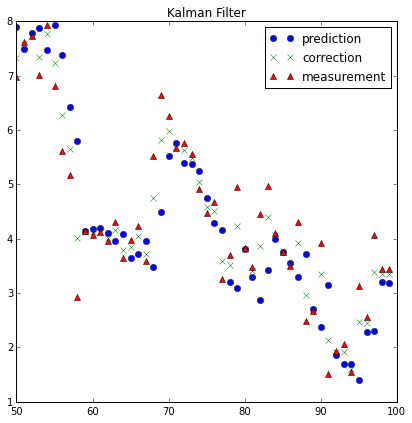

In [6]:
t = numpy.arange(50, 100)
fig = plt.figure(figsize=(15,15))

axes = fig.add_subplot(2, 2, 1)
axes.set_title("Kalman Filter")
axes.plot(t, numpy.array(predictions)[50:100, 0], 'o', label='prediction')
axes.plot(t, numpy.array(corrections)[50:100, 0], 'x', label='correction')
axes.plot(t, numpy.array(measurements)[50:100, 0], '^', label='measurement')
plt.legend()
plt.show()

## Conclusions
- Kalman Filter is a viable forecasting technique for time series
- Computationally more efficient
- Strang, Gilbert. *Computational Science and Engineering*
![Gilbert_Strang](cupcakematrix.jpg)

## Thank you!
eramirem@gmail.com
<br>
@eramirem